# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [118]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [5]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD5.xlsx', sheet_name = 'reactions')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [6]:
# choose a flux set, and drop all of the zero-flux reactions
fluxSet = 'ppi-pfk'
selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent                                                        # processing
selectedRxnDf

,Name,AbbreviationFormula,KeggFormula,flux
0,ATPase1,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,2
1,CBP,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1
3,GLK-GTP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,1
5,PGMT,g1p <=> g6p,C00103 <=> C00092,1
6,PGI,g6p <=> f6p,C00092 <=> C00085,2
7,PFK-PPi,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,2
9,FBA,fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,2
10,TPI,dhap <=> g3p,C00111 <=> C00118,2
11,GAPDH,pi + nad + g3p <=> nadh + 13dpg,C00009 + C00003 + C00118 <=> C00004 + C00236,4
14,PGK-GTP,gdp + 13dpg <=> gtp + 3pg,C00035 + C00236 <=> C00044 + C00197,4


In [7]:
#Import metabolite data from excel file
Met_bound = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'metabolite_bounds')
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'KEGG_ID', 'compound','amount_int', 'Sample','Replicate','Maven filename']]
Met_data

,Timepoint,KEGG_ID,compound,amount_int,Sample,Replicate,Maven filename
0,2,C00197,3PG,217.958918,A,1,A1_1
1,2,C00197,3PG,137.397616,A,2,A1_2
2,5,C00197,3PG,22.518127,A,1,A2_1
3,5,C00197,3PG,32.297909,A,2,A2_2
4,9,C00197,3PG,18.098252,A,1,A3_1
5,9,C00197,3PG,23.483431,A,2,A3_2
6,2,C00197,3PG,174.009787,B,1,B1_1
7,2,C00197,3PG,229.718916,B,2,B1_2
8,5,C00197,3PG,191.881108,B,1,B2_1
9,5,C00197,3PG,234.758916,B,2,B2_2


In [8]:
Met_bound

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
0,C00008,adp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
1,C00020,amp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
2,C00002,atp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
3,C00010,coa,0.02000,0.000001,Cofactor,no,NaN,20000.0,1.0
4,C00139,fdxox,0.00010,0.000100,Cofactor,NaN,NaN,100.0,100.0
5,C00138,fdxrd,0.01000,0.000001,Cofactor,NaN,NaN,10000.0,1.0
6,C00035,gdp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
7,C00044,gtp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
8,C00003,nad,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
9,C00004,nadh,0.01000,0.000001,Cofactor,no,NaN,10000.0,1.0


In [9]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [10]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [144]:
# impose only one concentration bound at a time to check for infeasible bounds
all_data={}
Uf = 1.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    for i, dat in Met_data.iterrows():
        for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
            pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        # skip cofactors and impose bound on metsbolites one at a time    
        if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep) and (dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00469"]):
            all_data[sm][i]={}
            lb = dat['amount_int']/(Uf *1e6)
            ub = dat['amount_int']/1e6 *Uf
            if lb < DEFAULT_LB:    
                lb = DEFAULT_LB

            if lb > DEFAULT_UB:
                lb = DEFAULT_UB

                        
   
            if ub < DEFAULT_LB:
                ub = DEFAULT_LB

            if ub > DEFAULT_UB:
                ub = DEFAULT_UB
                
            pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
            mdf_data = pp.calc_mdf()
            print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
            all_data[sm][cpd['KEGG_ID']]['sample']=smple
            all_data[sm][cpd['KEGG_ID']]['timepoint']=tym
            all_data[sm][cpd['KEGG_ID']]['replicate']=rep
            #all_data[sm][cpd['KEGG_ID']]['metab']=dat['KEGG_ID']
            all_data[sm][cpd['KEGG_ID']]['mdf']=mdf_data
            '''
            if mdf_data.mdf>0 :
                mdf_data, con = pp.conc_mdf()
                print(cpd2,tym,mdf_data.mdf)
                k=0
                for c in mdf_data.compound_data:
                    print(c.compound, mdf_data.model.concentration_bounds.GetBoundTuple(c.compound),con[k])
                    k=k+1
                    '''

A 2 1 C00197 2.229597358359591


KeyError: 'C00036'

In [ ]:
for j, cpd in Met_bound.iterrows():
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        print(" ")
        print(cpd['KEGG_ID'], end='')
        for sm in range(12): # divide the samples into datasets
            if sm < 6:
                smple = 'A'
            else:
                smple = 'B'
            if (sm)%3==0:
                tym = 2
            elif (sm)%3==1:
                tym = 5
            else:
                tym = 9
            if sm<3 or (sm<9 and sm>5):
                rep = 1
            else:
                rep = 2
            try:
                print(all_data[sm][cpd['KEGG_ID']]['mdf'], end='')
            except:
                print (" ")


In [110]:
all_data={}
Uf = 1.5 #Uncertainity factor 
 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
cnt=0
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    ditcur={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    ref_conc = {}
    for i, dat in Met_data.iterrows():
        if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep):
            ref_conc.update({dat['KEGG_ID']: dat['amount_int']/1e6 })
            if dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00111","C00354"]: 
                lb = dat['amount_int']/(Uf *1e6)
                ub = dat['amount_int']/1e6 *Uf
                if lb < DEFAULT_LB:    
                    lb = DEFAULT_LB

                if lb > DEFAULT_UB:
                    lb = DEFAULT_UB

                        
   
                if ub < DEFAULT_LB:
                    ub = DEFAULT_LB

                if ub > DEFAULT_UB:
                    ub = DEFAULT_UB
                
                pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            #if dat['KEGG_ID'] in ["C00024"]:
                #pp.bounds.SetBounds(dat['KEGG_ID'], dat['amount']/(1e6 * 3), dat['amount']/1e6 * 3)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
    mdf_data, con = pp.conc_mdf()
    print(sm,smple,tym,rep,mdf_data.mdf)
    ditcur['mdf']=mdf_data
    ditcur['conc']=con
    ditcur['c_bounds']={str(c.compound): (mdf_data.model.concentration_bounds.GetBoundTuple(str(c.compound))) for c in mdf_data.compound_data}
    all_data[sm]=ditcur
    #for c in mdf_data.compound_data:
        #print(c.compound, log(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)), sm,log(all_data[0]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)))
                
                
                

0 A 2 1 1.0792895402859344
1 A 5 1 0.0326391623427682
2 A 9 1 -0.22191304527481392
3 A 2 2 0.6908542551658137
4 A 5 2 0.6587834176944796
5 A 9 2 -0.2261995095895699
6 B 2 1 0.7851330012554243
7 B 5 1 1.1697876334268926
8 B 9 1 1.0482164778796665
9 B 2 2 0.5018098840897238
10 B 5 2 0.8527626152521783
11 B 9 2 0.7049630808297174


1.0792895402859344
pyr 0.0002752812749831511 (0.00012234723332584532, 0.0002752812749831516)
pep 3.7461161401198964e-05 (1.6649405067199563e-05, 3.7461161401198964e-05)
acald 0.0005747362398106036 (0.0005747362398105944, 0.0005747362398106138)
f6p 0.001008784274668722 (0.0010087842746686908, 0.0010087842746687229)
g6p 0.004321248595668487 (0.004321248595668345, 0.004321248595668484)
g1p 0.0007520097556718729 (0.00033423147738698226, 0.0007520097556718729)
dhap 0.004824648806537879 (0.0048246488065378105, 0.0048246488065379735)
g3p 0.000342246677987362 (0.0003422466779873571, 0.0003422466779873635)
0.0326391623427682
pyr 0.0004582022497129505 (0.00020364544431686698, 0.0004582022497129505)
pep 6.851800841895323e-06 (3.045244818620148e-06, 6.851800841895348e-06)
acald 0.00019406995829184478 (0.00019406995829184548, 0.00019406995829184478)
f6p 0.0018936467348773416 (0.0017497492832359628, 0.0018936467348773431)
g6p 0.005316749853536343 (0.004912732176507412, 0.0053167498535363475)
g1p 0.0

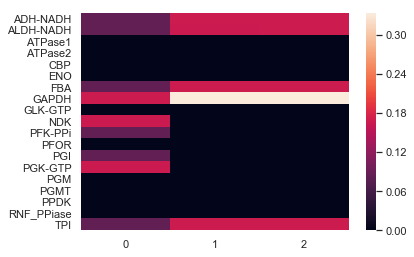

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fng_data={}
for t in range(3):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
    k=0
    print(all_data[t]['mdf'].mdf)
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if ktaDict[c.compound] in ["g6p", "f6p","g1p", "pyr","pep","dhap","g3p","acald"]:
            print(ktaDict[c.compound], (c.concentration),all_data[t]['conc'][k])
        #elif all_data[t]['conc'][k][1] >= all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)[1]:
            #print(c.compound, all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),all_data[t]['conc'][k])
        k=k+1
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

pyr 0.0003161689147974619 (0.00014051951768776053, 0.0003161689147974619)
pep 4.8582390405354844e-05 (2.159217351349107e-05, 4.8582390405354844e-05)
acald 0.0007750650659070722 (0.00015680983392925892, 0.0007750650659070805)
f6p 0.0011045533617416844 (0.0011045533617416836, 0.0011045533617416875)
g6p 0.004044922334341524 (0.004044922334341514, 0.004044922334341532)
g1p 0.0012218527104915899 (0.0005430456491073726, 0.0012218527104915877)
dhap 0.005460138211833341 (0.0024559595080716843, 0.01213908828477834)
g3p 0.00045306929843486456 (0.00020378968592680736, 0.0004530692984348674)
pyr 0.0005214868934790829 (0.00023177195265736941, 0.0005214868934790823)
pep 8.190203681459309e-06 (3.6400905250930304e-06, 8.190203681459338e-06)
acald 0.02 (0.0005069339346789952, 0.020000000000000028)
f6p 0.0015040842847703977 (0.001504084284770395, 0.0015040842847703923)
g6p 0.005437184549934107 (0.005437184549934107, 0.005437184549934093)
g1p 0.0046274017615625055 (0.002056623005138901, 0.004627401761562

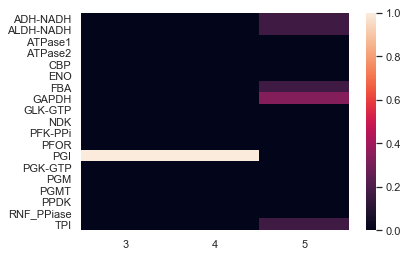

In [127]:
fng_data={}
for t in range(3,6):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if ktaDict[c.compound] in ["g6p", "f6p","g1p", "pyr","pep","dhap","g3p","acald"]:
            print(ktaDict[c.compound], (c.concentration),all_data[t]['conc'][k])
        #elif all_data[t]['conc'][k][1] >= all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)[1]:
            #print(c.compound, all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),all_data[t]['conc'][k])
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

pyr 0.0003306662300584468 (0.00014696276891486493, 0.0003306662300584462)
pep 4.332576574068018e-05 (1.925589588474677e-05, 4.332576574068018e-05)
acald 2.9867536320210838e-05 (8.342150129709998e-06, 0.00010693522796503824)
f6p 0.0012615928584293165 (0.0012615928584293165, 0.001261592858429313)
g6p 0.004799196132416998 (0.004799196132417011, 0.004799196132416998)
g1p 0.0017391611920378153 (0.0007729605297945884, 0.001739161192037823)
dhap 0.00572541538055577 (0.0015991367398866063, 0.02000000000000002)
g3p 0.0004573431793105286 (0.00012773820450753367, 0.00045734317931052577)
pyr 0.0013172785965478433 (0.0005854571540212635, 0.001317278596547841)
pep 4.709146658614683e-05 (2.6462007593122686e-05, 4.709146658614549e-05)
acald 4.7243255040595395e-05 (4.724325504059682e-05, 4.7243255040594887e-05)
f6p 0.001457205571522296 (0.0014572055715223633, 0.001457205571522301)
g6p 0.0064743304939380904 (0.006474330493938378, 0.006474330493938108)
g1p 0.0033535515447531265 (0.0014904673532236162, 0.

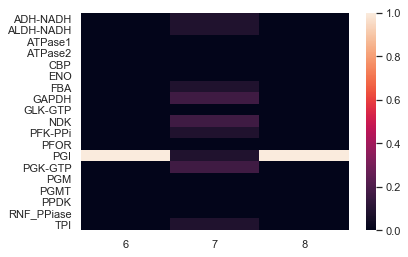

In [128]:
fng_data={}
for t in range(6,9):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if ktaDict[c.compound] in ["g6p", "f6p","g1p", "pyr","pep","dhap","g3p","acald"]:
            print(ktaDict[c.compound], (c.concentration),all_data[t]['conc'][k])
        #elif all_data[t]['conc'][k][1] >= all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)[1]:
            #print(c.compound, all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),all_data[t]['conc'][k])
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

pyr 0.0003493277354796076 (0.0001552567713242701, 0.0003493277354796082)
pep 5.348377380255596e-05 (2.3770566134469265e-05, 5.348377380255596e-05)
acald 0.00024878437785912457 (5.454874722500806e-06, 0.0002487843778591268)
f6p 0.0014617123964015951 (0.0014617123964015977, 0.0014617123964015977)
g6p 0.004959620987002141 (0.004959620987002141, 0.004959620987002141)
g1p 0.0018230093358035497 (0.0008102263714682454, 0.0018230093358035497)
dhap 0.006525438688554434 (0.0009662523230796646, 0.02000000000000001)
g3p 0.0005843965424037333 (8.65343379423313e-05, 0.0005843965424037348)
pyr 0.0027250369777071007 (0.0012111275456475998, 0.0027250369777070986)
pep 6.945716870992725e-05 (3.086985275996765e-05, 6.945716870992737e-05)
acald 2.8391496845129424e-05 (2.8391496845129827e-05, 2.8391496845129424e-05)
f6p 0.00147819372227997 (0.0014781937222799963, 0.0014781937222799752)
g6p 0.005778767066420713 (0.0057787670664208104, 0.005778767066420729)
g1p 0.003837637767928468 (0.0017056167857459848, 0.0

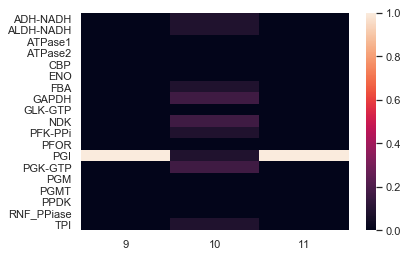

In [129]:
fng_data={}
for t in range(9,12):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if ktaDict[c.compound] in ["g6p", "f6p","g1p", "pyr","pep","dhap","g3p","acald"]:
            print(ktaDict[c.compound], (c.concentration),all_data[t]['conc'][k])
        #elif all_data[t]['conc'][k][1] >= all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)[1]:
            #print(c.compound, all_data[t]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),all_data[t]['conc'][k])
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)